The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [2]:
!pip install --no-deps git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l

  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-ov1_4oeb
  Running command git clone --filter=blob:none --quiet https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-ov1_4oeb
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Resolved https://github.com/d2l-ai/d2l-zh to commit 843d3d41dca48d8df65f4b324dd171d8bfe9c067
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for d2l: filename=d2l-2.0.0-py3-none-any.whl size=110800 sha256=4c8f0749129010f6897987fc286b1130dc15a9416700f5ea720dbaaa6085aa60
  Stored in directory: /tmp/pip-ephem-wheel-cache-1kg88l5w/wheels/3e/87/36/53b013ece7da539a59fcc56da2d329d7afb08eef9a9a5ae1d1
Successfully built d2l


# 稠密连接网络（DenseNet）

ResNet极大地改变了如何参数化深层网络中函数的观点。
*稠密连接网络*（DenseNet） :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`在某种程度上是ResNet的逻辑扩展。让我们先从数学上了解一下。

## 从ResNet到DenseNet

回想一下任意函数的泰勒展开式（Taylor expansion），它把这个函数分解成越来越高阶的项。在$x$接近0时，

$$f(x) = f(0) + f'(0) x + \frac{f''(0)}{2!}  x^2 + \frac{f'''(0)}{3!}  x^3 + \ldots.$$

同样，ResNet将函数展开为

$$f(\mathbf{x}) = \mathbf{x} + g(\mathbf{x}).$$

也就是说，ResNet将$f$分解为两部分：一个简单的线性项和一个复杂的非线性项。
那么再向前拓展一步，如果我们想将$f$拓展成超过两部分的信息呢？
一种方案便是DenseNet。

![ResNet（左）与 DenseNet（右）在跨层连接上的主要区别：使用相加和使用连结。](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/densenet-block.svg?raw=1)
:label:`fig_densenet_block`

如 :numref:`fig_densenet_block`所示，ResNet和DenseNet的关键区别在于，DenseNet输出是*连接*（用图中的$[,]$表示）而不是如ResNet的简单相加。
因此，在应用越来越复杂的函数序列后，我们执行从$\mathbf{x}$到其展开式的映射：

$$\mathbf{x} \to \left[
\mathbf{x},
f_1(\mathbf{x}),
f_2([\mathbf{x}, f_1(\mathbf{x})]), f_3([\mathbf{x}, f_1(\mathbf{x}), f_2([\mathbf{x}, f_1(\mathbf{x})])]), \ldots\right].$$

最后，将这些展开式结合到多层感知机中，再次减少特征的数量。
实现起来非常简单：我们不需要添加术语，而是将它们连接起来。
DenseNet这个名字由变量之间的“稠密连接”而得来，最后一层与之前的所有层紧密相连。
稠密连接如 :numref:`fig_densenet`所示。

![稠密连接。](http://d2l.ai/_images/densenet.svg)
:label:`fig_densenet`

稠密网络主要由2部分构成：*稠密块*（dense block）和*过渡层*（transition layer）。
前者定义如何连接输入和输出，而后者则控制通道数量，使其不会太复杂。

## (**稠密块体**)

DenseNet使用了ResNet改良版的“批量规范化、激活和卷积”架构（参见 :numref:`sec_resnet`中的练习）。
我们首先实现一下这个架构。


In [3]:
import torch
from torch import nn
from d2l import torch as d2l

def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

一个*稠密块*由多个卷积块组成，每个卷积块使用相同数量的输出通道。
然而，在前向传播中，我们将每个卷积块的输入和输出在通道维上连结。


In [4]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出
            X = torch.cat((X, Y), dim=1)
        return X

在下面的例子中，我们[**定义一个**]有2个输出通道数为10的(**`DenseBlock`**)。
使用通道数为3的输入时，我们会得到通道数为$3+2\times 10=23$的输出。
卷积块的通道数控制了输出通道数相对于输入通道数的增长，因此也被称为*增长率*（growth rate）。


In [5]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

## [**过渡层**]

由于每个稠密块都会带来通道数的增加，使用过多则会过于复杂化模型。
而过渡层可以用来控制模型复杂度。
它通过$1\times 1$卷积层来减小通道数，并使用步幅为2的平均汇聚层减半高和宽，从而进一步降低模型复杂度。


In [6]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [7]:
Y.shape

torch.Size([4, 23, 8, 8])

对上一个例子中稠密块的输出[**使用**]通道数为10的[**过渡层**]。
此时输出的通道数减为10，高和宽均减半。


In [8]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

## [**DenseNet模型**]

我们来构造DenseNet模型。DenseNet首先使用同ResNet一样的单卷积层和最大汇聚层。


In [9]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

接下来，类似于ResNet使用的4个残差块，DenseNet使用的是4个稠密块。
与ResNet类似，我们可以设置每个稠密块使用多少个卷积层。
这里我们设成4，从而与 :numref:`sec_resnet`的ResNet-18保持一致。
稠密块里的卷积层通道数（即增长率）设为32，所以每个稠密块将增加128个通道。

在每个模块之间，ResNet通过步幅为2的残差块减小高和宽，DenseNet则使用过渡层来减半高和宽，并减半通道数。


In [10]:
# num_channels为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

与ResNet类似，最后接上全局汇聚层和全连接层来输出结果。


In [13]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10)).cuda()

In [14]:
X=torch.rand(1,1,96,96).cuda()
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
DenseBlock output shape:	 torch.Size([1, 192, 24, 24])
Sequential output shape:	 torch.Size([1, 96, 12, 12])
DenseBlock output shape:	 torch.Size([1, 224, 12, 12])
Sequential output shape:	 torch.Size([1, 112, 6, 6])
DenseBlock output shape:	 torch.Size([1, 240, 6, 6])
Sequential output shape:	 torch.Size([1, 120, 3, 3])
DenseBlock output shape:	 torch.Size([1, 248, 3, 3])
BatchNorm2d output shape:	 torch.Size([1, 248, 3, 3])
ReLU output shape:	 torch.Size([1, 248, 3, 3])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 248, 1, 1])
Flatten output shape:	 torch.Size([1, 248])
Linear output shape:	 torch.Size([1, 10])


## [**训练模型**]

由于这里使用了比较深的网络，本节里我们将输入高和宽从224降到96来简化计算。


loss 0.142, train acc 0.948, test acc 0.888
1929.6 examples/sec on cuda:0


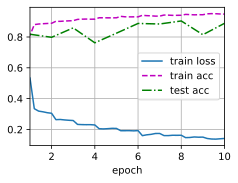

In [15]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结

* 在跨层连接上，不同于ResNet中将输入与输出相加，稠密连接网络（DenseNet）在通道维上连结输入与输出。
* DenseNet的主要构建模块是稠密块和过渡层。
* 在构建DenseNet时，我们需要通过添加过渡层来控制网络的维数，从而再次减少通道的数量。

## 练习

1. 为什么我们在过渡层使用平均汇聚层而不是最大汇聚层？
1. DenseNet的优点之一是其模型参数比ResNet小。为什么呢？
1. DenseNet一个诟病的问题是内存或显存消耗过多。
    1. 真的是这样吗？可以把输入形状换成$224 \times 224$，来看看实际的显存消耗。
    1. 有另一种方法来减少显存消耗吗？需要改变框架么？
1. 实现DenseNet论文 :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`表1所示的不同DenseNet版本。
1. 应用DenseNet的思想设计一个基于多层感知机的模型。将其应用于 :numref:`sec_kaggle_house`中的房价预测任务。


[Discussions](https://discuss.d2l.ai/t/1880)
